# Tutorial: DESI spectral fitting with `provabgs`

In [1]:
# lets install the python package `provabgs`, a python package for generating the PRObabilistic Value-Added BGS (PROVABGS)
!pip install git+https://github.com/changhoonhahn/provabgs.git --upgrade --user

  Cloning https://github.com/changhoonhahn/provabgs.git to /tmp/pip-req-build-g309s2xp
  Running command git clone -q https://github.com/changhoonhahn/provabgs.git /tmp/pip-req-build-g309s2xp
  Created wheel for provabgs: filename=provabgs-0.1-py3-none-any.whl size=14977699 sha256=3ffe4e5ddde014f797d27563225ad6c66375e8060ba8ac841fa127c9248cece0
  Stored in directory: /tmp/pip-ephem-wheel-cache-2d0dextm/wheels/50/b1/8c/96efdb74859fd559b23907d6b38eb2a97aa8362da66cbb7437
Successfully built provabgs
  Attempting uninstall: provabgs
    Found existing installation: provabgs 0.1
    Uninstalling provabgs-0.1:
      Successfully uninstalled provabgs-0.1


In [2]:
!pip install zeus-mcmc --user

In [3]:
import numpy as np 

In [4]:
from provabgs import infer as Infer
from provabgs import models as Models
from provabgs import flux_calib as FluxCalib

/global/homes/c/chahah/.local/lib/python3.8/site-packages/provabgs/models.py:25: UserWarning: import error with fsps; only use emulators
  warnings.warn('import error with fsps; only use emulators')


In [5]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [6]:
# read in DESI Cascades spectra from TILE 80612
from desispec.io import read_spectra

spectra = read_spectra('/global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80612/deep/coadd-0-80612-deep.fits')

INFO:spectra.py:253:read_spectra: iotime 0.771 sec to read coadd-0-80612-deep.fits at 2021-04-06T19:22:38.726213


In [7]:
igal = 10

In [8]:
from astropy.table import Table
zbest = Table.read('/global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80612/deep/zbest-0-80612-deep.fits', hdu=1)
zred = zbest['Z'][igal]
print('z=%f' % zred)

z=0.291254


(0.0, 5.0)

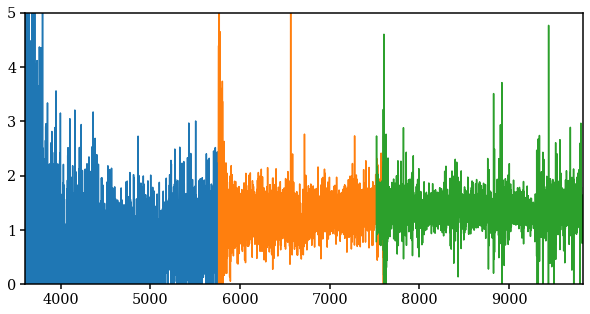

In [9]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spectra.wave['b'], spectra.flux['b'][igal])
sub.plot(spectra.wave['r'], spectra.flux['r'][igal])
sub.plot(spectra.wave['z'], spectra.flux['z'][igal])
sub.set_xlim(spectra.wave['b'].min(), spectra.wave['z'].max())
sub.set_ylim(0, 5)

In [10]:
# declare prior
priors = Infer.load_priors([
    Infer.UniformPrior(9., 12, label='sed'),
    Infer.FlatDirichletPrior(4, label='sed'), 
    Infer.UniformPrior(np.array([6.9e-5, 6.9e-5, 0., 0., -2.2]), np.array([7.3e-3, 7.3e-3, 3., 4., 0.4]), label='sed'), 
    Infer.UniformPrior(np.array([0.9, 0.9, 0.9]), np.array([1.1, 1.1, 1.1]), label='flux_calib') # flux calibration variables
    ])

# declare model
m_nmf = Models.NMF(burst=False, emulator=True)

# declare flux calibration 
fluxcalib = FluxCalib.constant_flux_DESI_arms

In [11]:
desi_mcmc = Infer.desiMCMC(
    model=m_nmf, 
    flux_calib=fluxcalib, 
    prior=priors
)

In [12]:
mcmc = desi_mcmc.run(
    wave_obs=[spectra.wave['b'], spectra.wave['r'], spectra.wave['z']],
    flux_obs=[spectra.flux['b'][igal], spectra.flux['r'][igal], spectra.flux['z'][igal]],
    flux_ivar_obs=[spectra.ivar['b'][igal], spectra.ivar['r'][igal], spectra.ivar['z'][igal]],
    zred=zred, 
    sampler='zeus',
    nwalkers=100, 
    burnin=100,
    opt_maxiter=10000,
    niter=1000, 
    debug=True)

--- initializing the walkers ---


/global/homes/c/chahah/.local/lib/python3.8/site-packages/provabgs/models.py:849: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/global/homes/c/chahah/.local/lib/python3.8/site-packages/provabgs/models.py:849: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
Initialising ensemble of 100 walkers...


initial theta = [10.560828980650623, 0.4366121397585645, 0.5544249583031693, 0.5598515045913397, 0.004560434294735009, 0.0029832155045308915, 0.0008661774856447682, 0.5796154065755563, -1.2872761922767997, 1.09999999350961, 1.09282449738282, 1.0668625561939813]
log Posterior(theta0) = -5574.276718
--- running MCMC ---


Sampling progress : 100%|██████████| 1100/1100 [1:18:44<00:00,  4.29s/it]

bestfit theta = [10.380970039158248, 0.006555927412312368, 0.07570301084368214, 0.5547376463122257, 0.3630034154317799, 9.390293841752902e-05, 7.165228030933237e-05, 0.0009368330315169507, 1.2157387699363729, -0.6985794116950433, 0.9016268353578096, 1.0708496500346216, 1.086885853585761]
log Posterior = -5090.655164
Model.sed: redshift = 0.291254
Model.sed: ssp lum [ 67343.11637751  70588.92312447  71209.42064938 ... 839591.95808903
 845578.47857423 847758.80644345]


(0.0, 5.0)

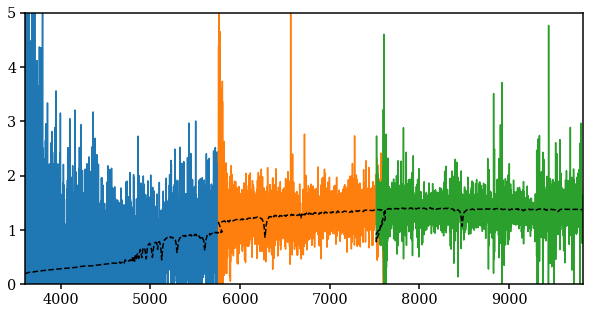

In [16]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spectra.wave['b'], spectra.flux['b'][igal])
sub.plot(spectra.wave['r'], spectra.flux['r'][igal])
sub.plot(spectra.wave['z'], spectra.flux['z'][igal])
sub.plot(mcmc['wavelength_obs'], mcmc['flux_spec_model'], c='k', ls='--')
sub.set_xlim(spectra.wave['b'].min(), spectra.wave['z'].max())
sub.set_ylim(0, 5)